In [1]:
import pandas as pd
import numpy as np

import sys
import os

from pathlib import Path
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
print(tf.config.list_physical_devices('GPU'))

[]


In [4]:
Emofilm = 'D:/Documents/emofilm/data/wav_corpus/'

In [5]:
fear_label = 'fear'
contempt_label = 'contempt'
happiness_label = 'happiness'
anger_label = 'anger'
sadness_label = 'sadness'
neutral_label = 'neutral'
surprise_label = 'surprise'

In [6]:
emofilm_info_df = pd.read_csv('D:/Documents/emofilm/data/complete_info.csv')
emofilm_info_df.head(2)

,file,speaker,film,emotion,language,transcritpion
0,f_ans001aen,Meryl Streep,the hours,ans,en,"[non-verbal] I don't know what's happening, I'..."
1,f_ans001aes,Rosa Guiñón,the hours,ans,es,"No sé lo que me pasa, lo siento."


In [7]:
emofilm_emotions = {
    'ans': fear_label,
    'dis': contempt_label,
    'gio': happiness_label,
    'rab': anger_label,
    'tri': sadness_label
}

# file_emotion = []
# file_path = []
emofilm_map = {'emotion': [], 'path': []}
for index, row in emofilm_info_df.iterrows():
    emofilm_map['emotion'].append(emofilm_emotions.get(row.emotion))
    emofilm_map['path'].append(os.path.join(Emofilm, row.file) + '.wav')


emofilm_df = pd.DataFrame(emofilm_map)
emofilm_df.head(2)

,emotion,path
0,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...
1,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...


In [8]:
data_df = pd.concat([emofilm_df], axis=0)
data_df.head()

,emotion,path
0,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...
1,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...
2,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...
3,fear,D:/Documents/emofilm/data/wav_corpus/f_ans002a...
4,fear,D:/Documents/emofilm/data/wav_corpus/f_ans002a...


augmentation functions


In [9]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data


def invert_polarity(data):
    return data * -1


def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5)*1000)
    return np.roll(data, shift_range)


def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


# taking any example and checking for techniques.
path = np.array(data_df.path)[1]
data, sample_rate = librosa.load(path)

feature extraction functions


In [10]:
def extract_features(data):
    result = np.array([])

    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(
        S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(
        y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result


def get_features(path):

    data, sample_rate = librosa.load(path)

    res1 = extract_features(data)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))  # stacking vertically

    inv_polarity_data = invert_polarity(data)
    res3 = extract_features(inv_polarity_data)
    result = np.vstack((result, res3))  # stacking vertically

    return result

In [11]:
def extract_zcr(data):
    return librosa.feature.zero_crossing_rate(y=data)


def extract_chroma_stft(data, sr):
    return librosa.feature.chroma_stft(y=data, sr=sr)


def extract_mfcc(data, sr):
    return librosa.feature.mfcc(y=data, sr=sr)


def extract_rms(data):
    return librosa.feature.rms(y=data)


def extract_melspectrogram(data, sr):
    return librosa.feature.melspectrogram(y=data, sr=sr, n_fft=512)

In [60]:
# This code was adapted from Nicolas Gervais on https://stackoverflow.com/questions/59241216/padding-numpy-arrays-to-a-specific-size on 1/10/2021
from numpy import ndarray


def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2, 0)
    aa = max(0, xx - a - h)
    b = max(0, (yy - w) // 2)
    bb = max(yy - b - w, 0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')


def fix_length(data: ndarray, length: int):
    fixed = data.reshape(len(data), 1)
    fixed = padding(fixed, length, 1)
    fixed = fixed.reshape(len(fixed))

    return fixed

In [13]:
data_df.head(2)

,emotion,path
0,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...
1,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...


In [36]:
max_length = 110250
max_i = 14
max_duration_s = librosa.get_duration(path=data_df['path'][14])
required_duration_millis = 5000

width = 250  # 5 seconds of adio is 200
height = 128  # melspectrogram height is 128

In [16]:
a, sr = librosa.load(data_df['path'][0])
print(a.shape, sr)

(48510,) 22050


In [57]:
width2 = int(required_duration_millis/1000*sr)

In [63]:
required_audio_size = 5  # audio of size 2 second needs to be padded to 5 seconds
# mono=True converts stereo audio to mono
# padded_audio = librosa.util.fix_length(
#     a, size=int(required_duration_millis/1000*sr))

padded_audio = fix_length(a, width2)

print('Array length before padding', np.shape(a))
print('Audio length before padding in seconds', (np.shape(a)[0]/sr))
print('Array length after padding', np.shape(padded_audio))
print('Audio length after padding in seconds', (np.shape(padded_audio)[0]/sr))
Audio(data=padded_audio, rate=sr)

Array length before padding (48510,)
Audio length before padding in seconds 2.2
Array length after padding (110250,)
Audio length after padding in seconds 5.0


In [ ]:
# p2 = fix_length(a, width2)

# print('Array length after padding2', np.shape(p2))
# print('Audio length after padding2 in seconds', (np.shape(p2)[0]/sr))
# Audio(data=p2, rate=sr)

In [19]:
def get_features_shapes(data, sample_rate):
    print('extract_zcr ', extract_zcr(data).shape)
    print('extract_chroma_stft ', extract_chroma_stft(data, sample_rate).shape)
    print('extract_mfcc ', extract_mfcc(data, sample_rate).shape)
    print('extract_rms ', extract_rms(data).shape)
    print('extract_melspectrogram ',
          extract_melspectrogram(data, sample_rate).shape)
    print('spectral_bandwidth ', librosa.feature.spectral_bandwidth(
        y=data, sr=sample_rate).shape)
    print('spectral_centroid ', librosa.feature.spectral_centroid(
        y=data, sr=sample_rate).shape)

In [20]:
get_features_shapes(a, sr)

extract_zcr  (1, 95)
extract_chroma_stft  (12, 95)
extract_mfcc  (20, 95)
extract_rms  (1, 95)
extract_melspectrogram  (128, 95)
spectral_bandwidth  (1, 95)
spectral_centroid  (1, 95)


In [ ]:
# extract_zcr(a)
# extract_chroma_stft(a, sr)
# extract_mfcc(a, sr)
# extract_rms(a)
# extract_melspectrogram(a, sr)

# result = extract_features(a)
# result.shape

(20, 216)


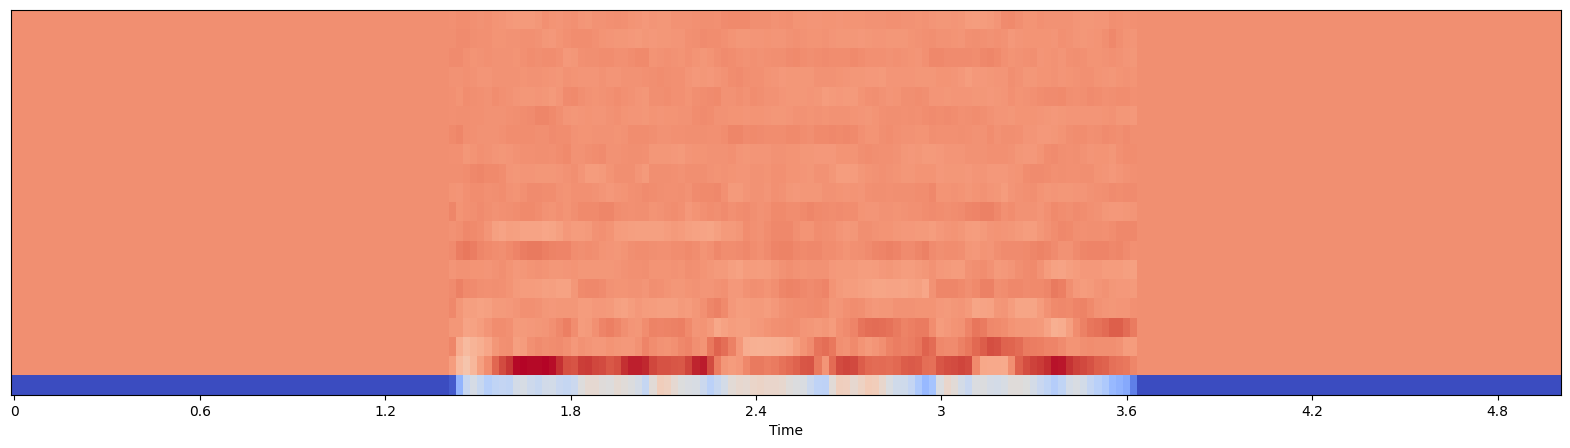

In [64]:
# MFCC
plt.figure(figsize=(20, 5))
mfccs = librosa.feature.mfcc(y=padded_audio, sr=sr)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')

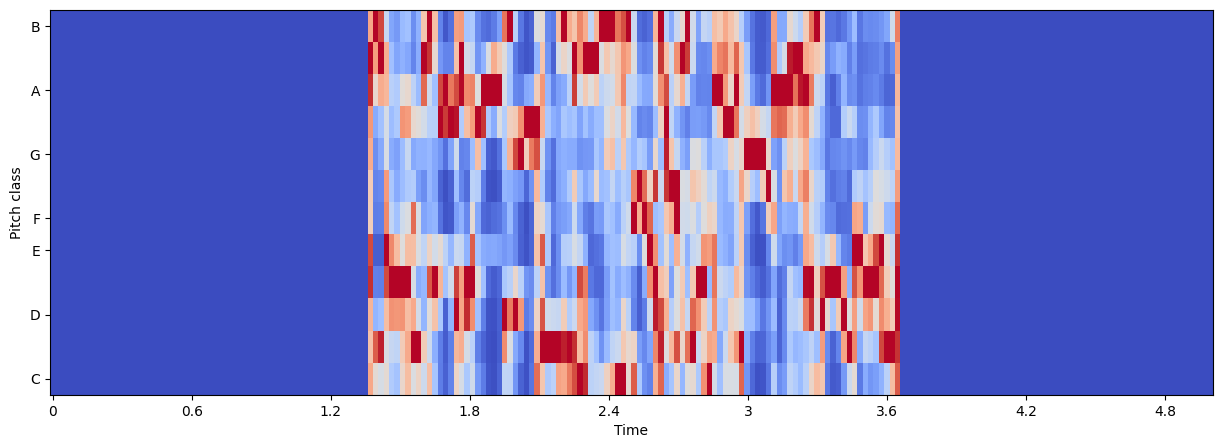

In [65]:
hop_length = 512
S = np.abs(librosa.stft(a))
chromagram = librosa.feature.chroma_stft(
    y=padded_audio, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time',
                         y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

In [66]:
print(mfccs.shape, chromagram.shape)

(20, 216) (12, 216)


In [170]:
from sklearn.preprocessing import normalize


def generate_features(y_cut):
    max_size = 200  # my max audio file feature width
    stft = padding(
        np.abs(librosa.stft(y_cut, n_fft=255, hop_length=512)), 128, max_size)
    MFCCs = padding(librosa.feature.mfcc(y=y_cut,
                    hop_length=hop_length, n_mfcc=128), 128, max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
    # Now the padding part
    image = np.array([padding(normalize(spec_bw), 1, max_size)]
                     ).reshape(1, max_size)
    image = np.append(image, padding(
        normalize(spec_centroid), 1, max_size), axis=0)
    # repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
    for i in range(0, 9):
        image = np.append(image, padding(
            normalize(spec_bw), 1, max_size), axis=0)
        image = np.append(image, padding(
            normalize(spec_centroid), 1, max_size), axis=0)
        image = np.append(image, padding(
            normalize(chroma_stft), 12, max_size), axis=0)
    image = np.dstack((image, np.abs(stft)))
    image = np.dstack((image, MFCCs))
    return image


def generate_features_spectogram(data):
    spec_bw = librosa.feature.spectral_bandwidth(y=data, sr=sr)
    spec_centroid = librosa.feature.spectral_centroid(y=data, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=data, sr=sr)
    zcr = extract_zcr(data=data)
    rms = extract_rms(data=data)

    stft = np.abs(librosa.stft(data, n_fft=255, hop_length=512))
    MFCCs = librosa.feature.mfcc(
        y=data, hop_length=hop_length, n_mfcc=height)
    mels = extract_melspectrogram(data=data, sr=sr)

    image = generate_image(spec_bw, spec_centroid, zcr,
                           rms, chroma_stft, stft, MFCCs)

    return image


def generate_image(spec_bw, spec_centroid, zcr, rms, chroma_stft, stft, MFCCs, img_height=128, use_normalize=True):
    image_width = spec_bw.shape[1]

    image = np.zeros((0, image_width))

    for i in range(0, 8):
        image = np.append(image, padding(
            normalize(spec_bw), 1, image_width), axis=0)
        image = np.append(image, padding(
            normalize(spec_centroid), 1, image_width), axis=0)
        image = np.append(image, padding(
            normalize(zcr), 1, image_width), axis=0)
        image = np.append(image, padding(
            normalize(rms), 1, image_width), axis=0)
        image = np.append(image, padding(
            normalize(chroma_stft), 12, image_width), axis=0)

    if (image.shape[0] != img_height or stft.shape[0] != img_height or MFCCs.shape[0] != img_height):
        print(
            f'Incorrect sizes\nimage.shape={image.shape}\tstft.shape={stft.shape}\tMFCCs.shape={MFCCs.shape}')
        return image

    if (use_normalize):
        stft = padding(
            normalize(stft), img_height, image_width)
        MFCCs = padding(
            normalize(MFCCs), img_height, image_width)

    image = np.dstack((image, stft))
    image = np.dstack((image, MFCCs))

    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


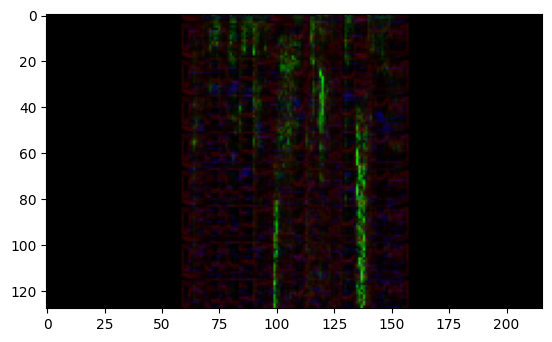

In [171]:
image2 = generate_features_spectogram(padded_audio)
plt.imshow(image2)

get features


In [145]:
spec_bw = librosa.feature.spectral_bandwidth(y=padded_audio, sr=sr)
spec_centroid = librosa.feature.spectral_centroid(y=padded_audio, sr=sr)
chroma_stft = librosa.feature.chroma_stft(y=padded_audio, sr=sr)
zcr = extract_zcr(data=padded_audio)
rms = extract_rms(data=padded_audio)

stft = np.abs(librosa.stft(padded_audio, n_fft=255, hop_length=512))
MFCCs = librosa.feature.mfcc(
    y=padded_audio, hop_length=hop_length, n_mfcc=height)
mels = extract_melspectrogram(data=padded_audio, sr=sr)

print(spec_bw.shape, spec_centroid.shape,
      chroma_stft.shape, zcr.shape, rms.shape, stft.shape, MFCCs.shape, mels.shape)

(1, 216) (1, 216) (12, 216) (1, 216) (1, 216) (128, 216) (128, 216) (128, 216)


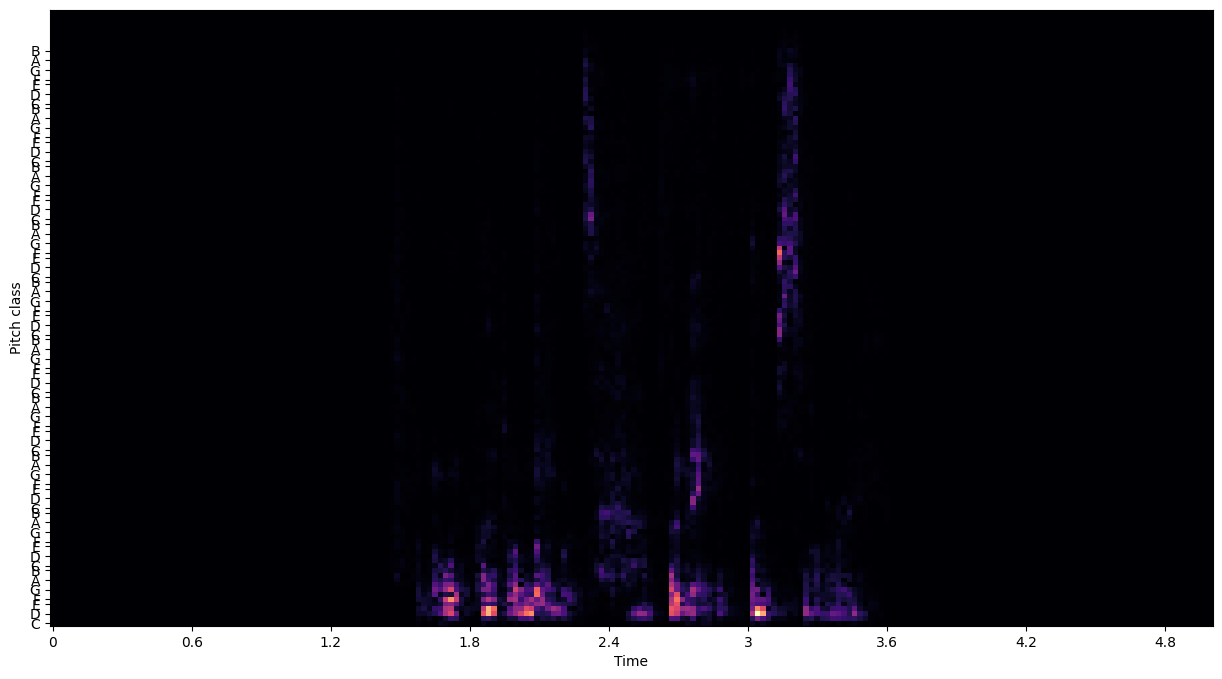

In [133]:
plt.figure(figsize=(15, 8))
librosa.display.specshow(stft, x_axis='time',
                         y_axis='chroma', hop_length=512)
plt.show()

add padding to features -- skip (use padded audio to extract features in first place)


In [106]:
# spec_bw = padding(spec_bw, 1, width)
# spec_centroid = padding(spec_centroid, 1, width)
# chroma_stft = padding(chroma_stft, 1, width)
# zcr = padding(zcr, 1, width)
# rms = padding(rms, 1, width)

# stft = padding(stft, height, width)
# MFCCs = padding(MFCCs, height, width)
# mels = padding(mels, height, width)


# print(spec_bw.shape, spec_centroid.shape,
#       chroma_stft.shape, zcr.shape, rms.shape, stft.shape, MFCCs.shape, mels.shape)

(1, 216) (1, 216) (12, 216) (1, 216) (1, 216) (300, 216) (128, 216) (128, 216)


In [72]:
plt.figure(figsize=(10, 5))
librosa.display.specshow(stft, x_axis='time',
                         y_axis='linear', hop_length=512)
plt.show()

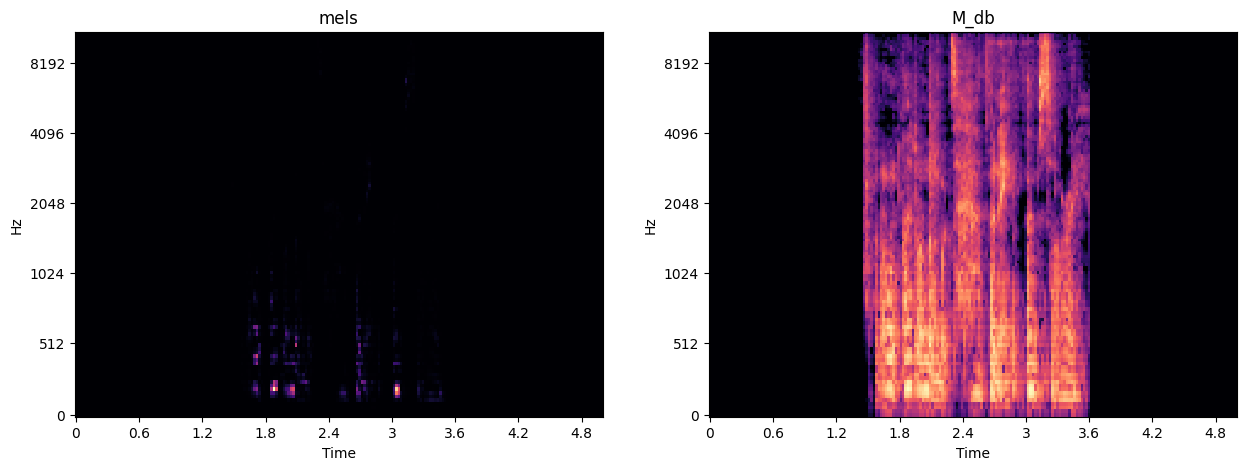

In [73]:
M_db = librosa.power_to_db(mels, ref=np.max)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# plt.figure(figsize=(10, 5))

librosa.display.specshow(mels, x_axis='time', ax=ax1,
                         y_axis='mel', hop_length=512)
librosa.display.specshow(M_db, x_axis='time', ax=ax2,
                         y_axis='mel', hop_length=512)
ax1.set_title('mels')
ax2.set_title('M_db')
plt.show()

combine features into image with 3 layers


128 / 16 = 8 -> features 8 times to match mfccs and features height


In [88]:
print(spec_bw.shape, spec_centroid.shape,
      chroma_stft.shape, zcr.shape, rms.shape)

image_width = spec_bw.shape[1]
print(width, width2, image_width)

(1, 216) (1, 216) (12, 216) (1, 216) (1, 216)
250 110250 216


In [161]:
image = np.zeros((0, 216))

for i in range(0, 8):
    image = np.append(image, padding(
        normalize(spec_bw), 1, image_width), axis=0)
    image = np.append(image, padding(
        normalize(spec_centroid), 1, image_width), axis=0)
    image = np.append(image, padding(
        normalize(zcr), 1, image_width), axis=0)
    image = np.append(image, padding(
        normalize(rms), 1, image_width), axis=0)
    image = np.append(image, padding(
        normalize(chroma_stft), 12, image_width), axis=0)

image.shape

(128, 216)

In [162]:
image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

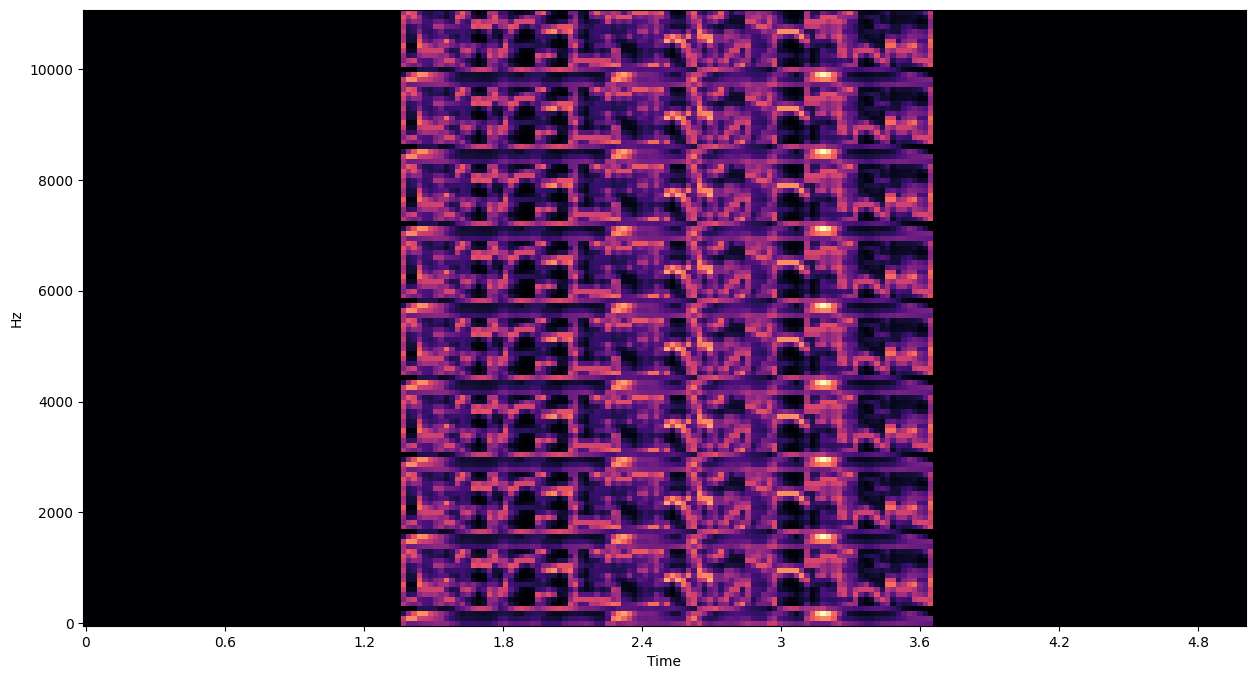

In [163]:
plt.figure(figsize=(15, 8))
librosa.display.specshow(image, x_axis='time',
                         y_axis='linear', hop_length=512)
plt.show()

Combine into single image


In [164]:
stft_n = padding(
    normalize(stft), 128, image_width)

MFCCs_n = padding(
    normalize(MFCCs), 128, image_width)

image = np.dstack((image, stft_n))
image = np.dstack((image, MFCCs_n))

In [165]:
# image = np.dstack((image, stft))
# image = np.dstack((image, MFCCs))

In [166]:
image.shape

(128, 216, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


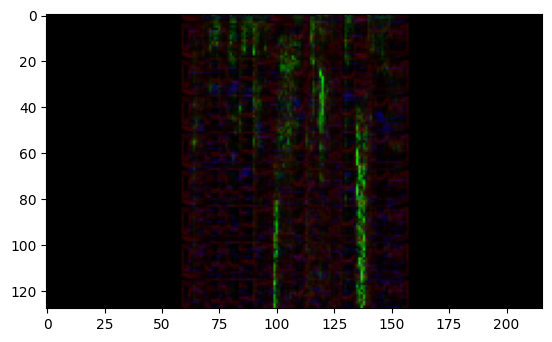

In [167]:
plt.imshow(image)

## Modeling


## Stuff


Something else...


In [ ]:
image = np.array([padding(normalize(spec_bw), 1, 200)]).reshape(1, width)

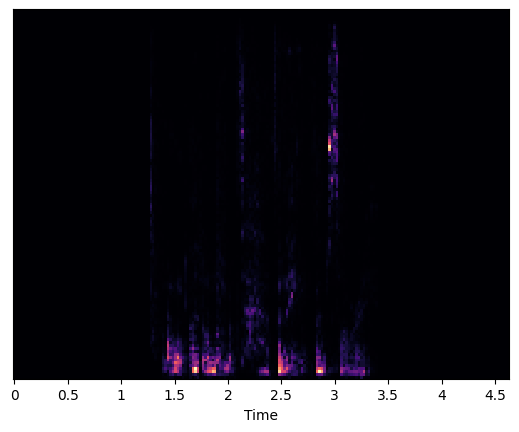

In [82]:
stft = padding(
    np.abs(librosa.stft(a, n_fft=255, hop_length=512)), 128, 200)
librosa.display.specshow(stft, sr=sr, x_axis='time')

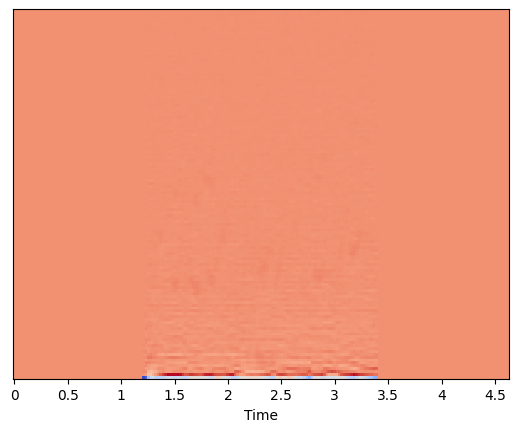

In [91]:
MFCCs = padding(librosa.feature.mfcc(y=a,
                                     hop_length=hop_length, n_mfcc=128), 128, 200)
librosa.display.specshow(MFCCs, sr=sr, x_axis='time')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


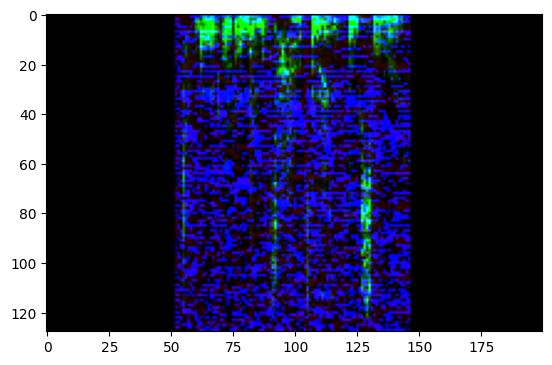

In [98]:
test = generate_features(a)
plt.imshow(test)

In [ ]:
# X, Y = [], []
# for path, emotion in zip(data_df.path, data_df.emotion):
#     features = get_features(path)
#     for ele in features:
#         X.append(ele)
#         Y.append(emotion)

# Features = pd.DataFrame(X)
# Features['labels'] = Y
# # Features.to_csv('features.csv', index=False)
# Features.head()